In [1]:
import os
import django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'rest.settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

In [2]:
from quiz.models import Pattern, HistoricalPatternActionPoint
from bourse_refs_api.models import StockHistory

In [3]:
import numpy as np
import pandas as pd
import pandas_ta as ta

from datetime import datetime
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

In [5]:
queryset = list(StockHistory.objects.all().values())
history_df = pd.DataFrame(queryset)
history_df.stock_id = list(map(lambda x: str(x['stock_id']), queryset))

In [28]:
history_df = history_df.sort_values(['stock_id', 'date'])

In [29]:
history_df = history_df.rename(columns={
    'max_price': 'high',
    'min_price': 'low',
    'last_deal_price': 'close',
    'first_price': 'open',
})

In [30]:
history_df

,stock_id,date,id,high,low,last_price,close,open,yesterday_price,value,volume,count
0,10024128313803797,2018-07-01,199359,4630,4402,4560,4449,4626,4518,1222345057,268076,70
1,10024128313803797,2018-07-02,199817,4610,4450,4480,4577,4610,4560,209031753,46661,27
2,10024128313803797,2018-07-03,200305,4610,4444,4471,4500,4610,4480,103204318,23083,23
3,10024128313803797,2018-07-04,200764,4448,4250,4318,4370,4443,4471,1362830638,315589,122
4,10024128313803797,2018-07-07,201242,4500,4230,4398,4445,4435,4318,722818025,164366,88
...,...,...,...,...,...,...,...,...,...,...,...,...
426144,9987529074833218,2021-08-09,464897,2661,2661,2661,2661,2661,2715,6632050215,2492315,105
426145,9987529074833218,2021-08-10,465614,2608,2608,2630,2608,2608,2661,2910530608,1116001,107
426146,9987529074833218,2021-08-11,466212,2700,2525,2586,2640,2525,2630,87206708928,33725442,2673
426147,9987529074833218,2021-08-14,466893,2637,2586,2632,2637,2637,2586,47145618452,17914812,1306


In [137]:
queryset = list(HistoricalPatternActionPoint.objects.filter(pattern_id='2crows').values())
pattern = pd.DataFrame(queryset)
pattern.stock_id = list(map(lambda x: str(x['stock_id']), queryset))

In [138]:
pattern

,id,pattern_id,stock_id,date,value
0,1,2crows,10120557300120078,2018-08-04,-100
1,2,2crows,10120557300120078,2019-07-16,-100
2,3,2crows,10568944722570445,2018-11-03,-100
3,4,2crows,11129387075131725,2021-01-06,-100
4,5,2crows,11403770140000603,2019-11-24,-100
...,...,...,...,...,...
699,700,2crows,9211775239375291,2020-03-04,-100
700,701,2crows,9481703061634967,2018-10-22,-100
701,702,2crows,9698674686691945,2019-12-21,-100
702,703,2crows,9698674686691945,2020-05-12,-100


In [103]:
def trend(pivot, ma=14):
    history = history_df[
        (history_df.stock_id == pivot.stock_id) &
        (history_df.date >= pivot.date - relativedelta(days=14)) &
        (history_df.date <= pivot.date + relativedelta(days=60))
    ].set_index('date').sort_index()
    
    if len(history) < ma:
        return { 'change': 0, 'time': 0 }
    
    sma = ta.sma(history.close, length=ma).dropna()
    
    suprimums = pd.concat([
        sma[(sma.shift(1) < sma) & (sma.shift(-1) < sma)],
        sma[(sma.shift(1) > sma) & (sma.shift(-1) > sma)]]
    )
    
    if len(suprimums) > 0:
        suprimum_date = suprimums.index[0] - relativedelta(days=ma//2)
    else:
        suprimum_date = history.index[-1] - relativedelta(days=ma//2)
    
    try:
        suprimum_entry = history.loc[suprimum_date]
    except:
        suprimum_entry = history.loc[history.index[history.index.searchsorted(suprimum_date)]]
        
    return {
        'change': (suprimum_entry.close / history.loc[pivot.date, 'close'] - 1) * 100,
        'time': (suprimum_date - pivot.date).days
    }

In [142]:
for value, group in pattern.groupby('value'):
    performance_list = []
    for i in tqdm(range(len(pattern))):
        p = pattern.loc[i]
        performance_list.append(trend(p))
    perdf = pd.DataFrame(performance_list)
    perdf = perdf[(perdf.change != 0) & (perdf.time > 0)]

/var/folders/dr/l8_gry7975l0f3fl8m62sdbh0000gn/T/ipykernel_18085/203940825.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(pattern))):


  0%|          | 0/704 [00:00<?, ?it/s]

In [106]:
performance_list = []
for i in tqdm(range(len(pattern))):
    p = pattern.loc[i]
    performance_list.append(trend(p))

/var/folders/dr/l8_gry7975l0f3fl8m62sdbh0000gn/T/ipykernel_18085/915902642.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(pattern))):


  0%|          | 0/2579 [00:00<?, ?it/s]

In [118]:
perdf = pd.DataFrame(performance_list)
perdf = perdf[(perdf.change != 0) & (perfdf.time > 0)]

<AxesSubplot:>

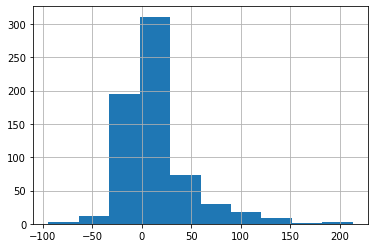

In [143]:
perdf.change.hist()

In [144]:
perdf

,change,time
0,-1.602374,1
2,-10.898690,25
3,-30.806258,53
4,55.228671,35
5,15.167613,24
...,...,...
698,5.601966,9
699,-11.658736,19
700,-20.972644,51
701,-0.076695,4


In [145]:
perdf.change.mean()

13.26949958008484

In [146]:
perdf.change.std()

33.06976695678687

In [147]:
len(perdf[perdf.change > 0]) / len(perdf)

0.6113671274961597

In [148]:
perdf.time.mean()

22.89400921658986

In [149]:
perdf.time.std()

16.425481453472724

<AxesSubplot:>

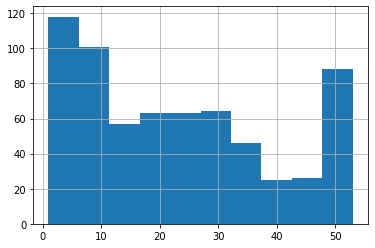

In [150]:
perdf.time.hist()

In [154]:
perdf.describe()

,change,time
count,651.000000,651.000000
mean,13.269500,22.894009
std,33.069767,16.425481
min,-94.316043,1.000000
25%,-3.738013,8.000000
50%,4.174573,21.000000
75%,21.758089,35.000000
max,213.175676,53.000000


<AxesSubplot:>

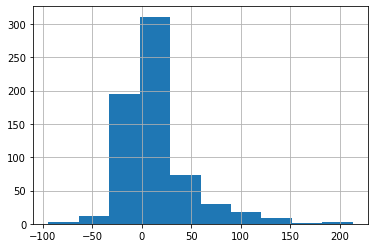

In [152]:
perdf.change.hist()

In [160]:
group.sample(frac=1).reset_index(drop=True)

,id,pattern_id,stock_id,date,value
0,456,2crows,52206600101613041,2020-08-19,-100
1,537,2crows,60350996279289099,2020-02-18,-100
2,693,2crows,8646067353086740,2019-01-09,-100
3,676,2crows,7503669593172728,2019-05-26,-100
4,31,2crows,13227300125161435,2018-09-03,-100
...,...,...,...,...,...
699,701,2crows,9481703061634967,2018-10-22,-100
700,378,2crows,44969149970836673,2018-09-11,-100
701,422,2crows,48981174642799639,2019-07-24,-100
702,278,2crows,35424116338766901,2020-01-27,-100
